# Breast Cancer Tumor Diagnosis - Neural Network from First Principals

Hi there, welcome to my first Kaggle Kernel!  The purpose of this Kernel is to develop a neural network that is capable of accurately predicting whether a tumor is benign or malignant, given several measurements.

The dataset we will be using is the 'Breast Cancer Wisconsin (Diagnostic) Data Set'.  The dataset contains 569 patients with breast tumors.  Several measurements and a diagnosis of malignant and benign are available for each patient.  The measurements will be used as features to make our predictions on the diagnosis. 

The neural network we will be developing will be derived from first principals (this means no Python packages such as scikit-learn will be used).

Lets begin by loading in our dataset and taking a look at it's structure.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [3]:
dataset=pd.read_csv("data.csv")

In [4]:
dataset.head() #lets take a look at our data structure

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
dataset.shape #Let's take a look at the dimensions of our data

(569, 33)

The data has 569 rows, each representing a single patient, with 28 measurements each (note: there are 31 columns, but column 1 is an ID, column 2 is a diagnosis, and the 32nd is not a measurement)

We are now going to proceed by massaging the data.  The following steps will be taken to prepare the data for our neural network:
*  Replace the diagnosis of "M" for malignant with 1, and "B" for benign with 0
*  Remove the 32nd column (not sure why this is included, it is a column of 'NaN' values.  Perhaps this was erroneously included in the dataset)
* Remove the 'id' column.  These values will not be needed to create our neural network.
*  Split our dataset into two: a calssification vector (diagnosis) and our feature matrix (the 28 measurements)
* Normalize our feature matrix by forcing the mean of each measurement  to 0, and dividing each measurement by the maximum value of that measurement in the dataset.

In [6]:
d = {'M':1,'B':0}
dataset = dataset.replace(d) #replace M/B with 0 or 1 for the neural net classification
dataset = dataset.drop(['Unnamed: 32'],axis=1) #remove column 32 - unknown purpose
dataset = dataset.drop(['id'],axis=1) #remove the id - not needed for the neural net

In [7]:
dataset_temp = dataset.drop(['diagnosis'],axis=1) #make a temporary dataset with only our feature vectors
X = np.array(dataset_temp).T #create our Numpy array of feature vectors to be used in our neural net
Y = np.array(dataset['diagnosis']).T #create our Numpy array of diagnosis to be used in our neural net
Y = Y.reshape(1,569)

In [8]:
#Now, let's normalized our feature vector.  We will force the mean of each column to 0, and divide by the maximum
X_mean = np.mean(X,axis=1,keepdims=True) #Find the mean of each feature
X_max = np.max(X,axis=1,keepdims=True) #Find the maximum of each feature
X_normalized = (X-X_mean)/(X_max) #Normalizing our dataset by subtracting the mean and dividing by the max

Our data is almost ready to be used to create our neural network.  Before doing so, we will split our data into a test set and a cross-validation set.

The training set will use the first 380 patients, and the cross-validation set will use the remaining 188.  Our neural network will be trained on the training set, and it's accuracy will be validated on the cross-validation set.

In [9]:
#Now, let's split our dataset into two segments
# 1) Training set to train our neural net
# 2) A cross validation set to test the accuracy of our neural net

#We'll take the first 380 samples for our training set
X_train = X_normalized[:,:380]
Y_train = Y[:,:380]

#We will take the remaining 189 for our cross-validation set
X_cv = X_normalized[:,381:]
Y_cv = Y[:,381:]

Now that our data has been massaged and split into our training and cross-validation sets, we can discuss the structure of the neural network.

* The neural network will have one input layer, two hidden layers, and one output layer.
* Hidden layer 1 will have 3 nodes, and hidden layer 2 will have 2 nodes.
* The two hidden layers will use a tanh(x) activation function, and the output layer will use a sigmoid activation function. 

*Note:  I have decided to use tanh(x) rather than sigmoid(x) in the hidden layers, as this will allow the data to be more centered*

See below for a visual representation of our neural network:

<img src="https://i.imgur.com/ZNLunIV.png" width="500px"/>

We will now define our activation functions to be used in our hidden layers:

In [10]:
#We will now define our sigmoid function to be used in the output layer of our neural network (L3)
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [11]:
#We will now define our tanh(x) function to be used in hidden layers of our neural network (L1, L2)
#Note that the tanh(x) function allows better centering of data than the sigmoid function.  This is why it will be used in our hidden layers.

def tanh(z):
    s = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    return s

We now have our activation functions, and can proceed with defining our forward propogation algorithm.

To optimize our code, we will be using a vectorized implementation of forward propogation.  To do so, the following formulas will be used:

*Note: x means matrix multiplication*

**Layer 1**

* Z1 = W1.T x X where W1 represents our matrix of weights in L1, and X represents our feature matrix of measures
* A1 = tanh(Z1 + b1) where b1 represents our intercept term for our first layer

**Layer 2**

* Z2 = W2.T x A1 where W2 represents our matrix of weights in L2
* A2 = tanh(Z2 + b2) where b2 represents our intercept term for our second layer

**Layer 3**

* Z3 = W3.T x A2 where W3 represents our matrix of weights in L3
* A3= tanh(Z3 + b3) where b3 represents our intercept term for our second layer

Finally, we will store all of the above Al and Zl values in a data dictionary, which will be useful for our back propogation and gradient descent algorithm.


In [12]:
#Now, let's define our forward propogation function.
def forward_prop(X,W1,W2,W3,b1,b2,b3):
    
    #First layer forward propogation
    Z1 = np.dot(W1,X)
    A1 = tanh(Z1 + b1)
    #Second layer forward propogation
    Z2 = np.dot(W2,A1)
    A2 = tanh(Z2 + b2)
    #Third layer forward propogation
    Z3 = np.dot(W3,A2)
    A3 = sigmoid(Z3 + b3) #A3 will produce our probability vector
    
    cache = {    
                  "Z1": Z1,
                  "A1": A1,
                  "Z2": Z2,
                  "A2": A2,
                  "Z3": Z3,
                  "A3": A3
            }
    return cache

Now that we have our forward propogation algorithm, we can proceed with back propogation and gradient descent.  The following steps will be carried out to perform gradient descent, and determine our optimized weight values for each layer:

1. Start by randomly initializing our weight and intercept parameters
1. Run forward propogation through our neural network
1. Calculate the derivatives of our weights and intercept parameters via back propogation
1. Refine our parameters using derivatives from (3)
1. Reiterate 1 - 4 x times

Our cost function will be defined by the following:

>cost = -(1 / m)*np.sum(np.multiply(Y,np.log(A3)) + np.multiply((1-Y),np.log(1-A3)))

>Where m is the number of training examples we are using. 

>*This is the general cost function often used when the output layer activation is a sigmoid function.  For those familiar with statistics, this is derived using maximum likelihood.*


The following general formulas will be used for calculating our weight derivatives for each layer (note these are partial derivatives w.r.t to the cost function described above).  

The general results can be derived using the chain rule (many times!):

>Note: * means element wise multiplication

> dZ[l] = dA[l]  * g'[l]{Z[l]} where g'[l]{Z[l]} is the derivative of our activation function at layer l, evaluated at Z[l]

>dA[l-1] = W[l].T x dZ[l]

>Finally,

>**dW[l] = (1 / m)*dZ[l] x A[l-1].T**

>and

>**db[l] =(1 / m) * column sum of dZ[l]**


Our parameters will be updated using the following formula after each iteration to bring the cost function closer to it's global minimum:

alpha = 'learning rate' hyperparameter


>W1 := W1 - alpha*dW1

>W2 := W2 - alpha*'W2

>W3 := W3 - alpha*W3

>b1 := b1 - alpha*b1

>b2 := b2 - alpha*db2

>b3 := b3 - alpha*db3


After each parameter update, we will rerun our forward propogation and calculate our cost function.  We will then store it in an array so we can use it in later analysis of our models performance.

One final note on the formulas above: for the first iteration of back propogation, dA[3] = -Y/A3 + (1-Y)/(1-A)

In [13]:
#Now we will perform gradient descent for our neural network in the following steps:
#1) Start by randomly initializing our weight and intercept parameters
#2) Run forward propogation through our neural network
#3) Calculate the derivatives of our weights and intercept parameters via back propogation
#4) Refine our parameters using derivatives from (3)
#5) Reiterate 1 - 4 

def gradient_descent(iterations,X,Y,alpha):
    
    #Randomly initialized our parameters before running the algorithm
    W1 = np.random.randn(3,30)*0.01
    b1 = np.random.rand(3,1)
    W2 = np.random.randn(2,3)*0.01
    b2 = np.random.rand(2,1)
    W3 = np.random.rand(1,2)*0.01
    b3 = np.random.rand(1,1)
    dummy,m = X.shape
    
    caches = [] #we will store our cost at each iteration in this array
    count_vector = [] #We will store our iteration count in this array
    count = 0
    
    for i in range (1,iterations):
        
            count = count + 1
            
            count_vector.append(count)
        
            params = forward_prop(X,W1,W2,W3,b1,b2,b3) #forward propogation using our parameters
            
            #Define our values to be used in back propogation using the dictionary of values created from running forward_prop
            Z1 = params['Z1']
            Z2 = params['Z2']
            Z3 = params['Z3']
            A1 = params['A1']
            A2 = params['A2']
            A3 = params['A3']
            
            #Define our cost function, append the cost of each iteration to caches
            cost = -(1 / m)*np.sum(np.multiply(Y,np.log(A3)) + np.multiply((1-Y),np.log(1-A3)))
            caches.append(cost)
            
            #Back propogation for layer 3
            dA3 = -Y/A3 + (1-Y)/(1-A3)
            dZ3 = dA3 * sigmoid(Z3)*(1-sigmoid(Z3))
            dW3 = (1 / m)*np.dot(dZ3,A2.T)
            db3 = (1 / m)*np.sum(dZ3,axis=1,keepdims=True)
            
            #Back propogation for layer 2
            dA2 = np.dot(W3.T,dZ3)
            dZ2 = dA2*(1-np.power(tanh(Z2),2))
            dW2 = (1 / m)*np.dot(dZ2,A1.T)
            db2 = (1 / m)*np.sum(dZ2,axis=1,keepdims=True)
            
            #Back propogation for layer 1
            dA1 = np.dot(W2.T,dZ2)
            dZ1 = dA1*(1-np.power(tanh(Z1),2))
            dW1 = (1 / m)*np.dot(dZ1,X.T)
            db1 = (1 / m)*np.sum(dZ1,axis=1,keepdims=True)
            
            #Redefine our weight parameters using the derivatives calculated in back propogation
            W1 = W1 - alpha*dW1
            W2 = W2 - alpha*dW2
            W3 = W3 - alpha*dW3
            
            #Redefine our weight parameters using the derivatives calculated in back propogation
            b1 = b1 - alpha*db1
            b2 = b2 - alpha*db2
            b3 = b3 - alpha*db3
        
    return W1,W2,W3,b1,b2,b3,count_vector,caches

Our gradient descent algorithm is complete.  Before proceeding, we should make sure that our algorithm has been coded correctly, and is behaving as expected.  Recall that we store our cost function values in an array.  We are now going to use them to validate that our algoirthm is behaving appropriately.

If our algorithm is working as intended, we should see, in general, a decreasing cost function with each iteration.  Additionally, we should see our cost function eventually flatten out.  This means that adding additional iterations doesn't help improve it much. Using our cross-validation set, let's select a learning rate (alpha) of 0.5, and plot our cost function value vs. our iterations over 1000 iterations to see if this pattern can be observed:

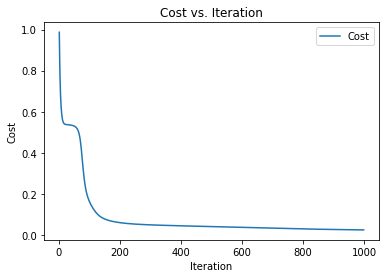

In [14]:
#Lets see if our algorithm is working.  We should see a declining learning curve with iteration, which eventually flatterns out
#This will help us determine the appropriate number of iterations to run to determine the appropriate parameters
#Note: we will use a learning rate of 0.5 for now

W1,W2,W3,b1,b2,b3,count,caches = gradient_descent(1000,X_cv,Y_cv,0.5)

plt.plot(count,caches,label='Cost')

plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.title("Cost vs. Iteration")

plt.legend()

plt.show()

Our algorithm is behaving as expected.  Now to complete our predictions vector.

Recall that the output of our neural network after performing forward propogation is a probability that a tumor is malignant, given our input vector X.  We therefore must set a certain 'threshold probability' for when we classify a tumor as malignant or benign.  Let's set our threshold to be 50%.  That is, if our model outputs a prediction of 0.5 or higher, we will classify the tumor as malignant.  Let's put this idea into code:

In [15]:

def predict(X,Y,iterations,alpha,X_train,Y_train):

    W1,W2,W3,b1,b2,b3,count,caches = gradient_descent(iterations,X_train,Y_train,alpha)
    
    Z1 = np.dot(W1,X)
    A1 = tanh(Z1 + b1)
    Z2 = np.dot(W2,A1)
    A2 = tanh(Z2 + b2)
    Z3 = np.dot(W3,A2)
    A3 = sigmoid(Z3 + b3)
    
    dummy,m = A3.shape
    Y_prediction = np.zeros((1, m))
    
    for i in range(m):
        
        Y_prediction[0, i] = 1 if A3[0, i] > 0.5 else 0
        
    return Y_prediction

We now have our vector of predictions, and we are ready to test the accuracy of our neural network.  

Let's test the accuracy on both the training set and cross-validation set.  We should expect to see the accuracy on the training set to be a little higher, due to the weight parameters being biased towards what it has been trained with.

In [16]:
#Lets see how accurate the predictions made by our neural network are compared to the training set and cross validation set
print("Train accuracy: {} %".format(100 - np.mean(np.abs(predict(X_train,Y_train,1000,0.5,X_train,Y_train) - Y_train)) * 100))
print("Cross validation accuracy: {} %".format(100 - np.mean(np.abs(predict(X_cv,Y_cv,1000,0.5,X_train,Y_train) - Y_cv)) * 100))

Train accuracy: 98.6842105263158 %
Cross validation accuracy: 96.80851063829788 %


Our predictions look great overall!  However, it is important to see the accuracy of predictions for both the malignant and benign tumors individually.

(E.g. is our accuracy only high because we're able to predict 100% of the negatives, but a smaller fraction (say, 80%) of the positives?)

Let's start by taking a look at how accurately we can predict malignant tumors:

In [17]:
dummy,m1 = X_train.shape
dummy,m2 = X_cv.shape

train_predict = predict(X_train,Y_train,1000,0.5,X_train,Y_train)
CV_predict = predict(X_cv,Y_cv,1000,0.5,X_train,Y_train)
count_true_pos = 0
count_train_pos = 0

count_true_pos_cv = 0
count_cv_pos = 0

for i in range (1,m1):
    if train_predict[0,i] == 1 and Y_train[0,i] == 1:
        count_true_pos = count_true_pos + 1
    if Y_train[0,i] == 1:
        count_train_pos = count_train_pos + 1
        
for i in range (1,m2):
    if CV_predict[0,i] == 1 and Y_cv[0,i] == 1:
        count_true_pos_cv = count_true_pos_cv + 1
    if Y_cv[0,i] == 1:
        count_cv_pos = count_cv_pos + 1
        
print(str(count_true_pos) + " positives predicted on the training set")
print(str(count_train_pos) + " true positives are in the training set")
print("The accuracy of true positives on the training set is: {} %".format(100-np.abs(100*((count_true_pos - count_train_pos)/count_train_pos))))
print("----------------------------------------------------------------")
print(str(count_true_pos_cv) + " positives predicted on the cross validation set")
print(str(count_cv_pos) + " true positives are in the cross validation set")
print("The accuracy of true positives on the cross validation set is: {} %".format(100-np.abs(100*((count_true_pos_cv - count_cv_pos)/count_true_pos_cv))))

    

165 positives predicted on the training set
168 true positives are in the training set
The accuracy of true positives on the training set is: 98.21428571428571 %
----------------------------------------------------------------
43 positives predicted on the cross validation set
43 true positives are in the cross validation set
The accuracy of true positives on the cross validation set is: 100.0 %


Accuracy looks great on predicting malignant tumors for both our training set and cross-validation set.

Now, let's take a look at how accurate the neural network is on predicting benign tumors:

In [18]:
count_true_neg = 0
count_train_neg = 0

count_true_neg_cv = 0
count_cv_neg = 0

for i in range (1,m1):
    if train_predict[0,i] == 0 and Y_train[0,i] == 0:
        count_true_neg = count_true_neg + 1
    if Y_train[0,i] == 0:
        count_train_neg = count_train_neg + 1
        
for i in range (1,m2):
    if CV_predict[0,i] == 0 and Y_cv[0,i] == 0:
        count_true_neg_cv = count_true_neg_cv + 1
    if Y_cv[0,i] == 0:
        count_cv_neg = count_cv_neg + 1
        
print(str(count_true_neg) + " negatives predicted on the training set")
print(str(count_train_neg) + " true negatives are in the training set")
print("The accuracy of true negatives on the training set is: {} %".format(100-np.abs(100*((count_true_neg - count_train_neg)/count_train_neg))))
print("----------------------------------------------------------------")
print(str(count_true_neg_cv) + " negatives predicted on the cross validation set")
print(str(count_cv_neg) + " true negatives are in the cross validation set")
print("The accuracy of true negatives on the cross validation set is: {} %".format(100-np.abs(100*((count_true_neg_cv - count_cv_neg)/count_true_neg_cv))))

210 negatives predicted on the training set
211 true negatives are in the training set
The accuracy of true negatives on the training set is: 99.5260663507109 %
----------------------------------------------------------------
138 negatives predicted on the cross validation set
144 true negatives are in the cross validation set
The accuracy of true negatives on the cross validation set is: 95.65217391304348 %


Accuracy looks good on predicting benign tumors for the training set and cross validation set

It looks like we have successfully created a neural network to accurately predict malignant or benign brain tumors!

#This concludes the Kernel.  Thank you for viewing!